First, let's import everything we need:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip
import math
import cmath

Now we define all relevant parameters:

In [2]:
# Natural units for particle and atomic physics
c = 1 # speed of light
hbar = 1 # Planck constant
eps0 = 1 # vacuum permittivity
# other parameters
## Fock space dimensions, should be infinite
dim_cav = 5
dim_env = 40
## cross-sectional area of cavity
sz_cav = 1
## monochromatic laser, average 10 photons, no phase
alpha = math.sqrt(10)
## Natural frequency of the qubit
freq = 1
## interaction strengths
g_env = 0.1
g_sc = 0.1
## Location of the "photon detector"
loc_out = 1

Now let's start with free Hamiltonians. For some reasons the [Shanghai Jiao Tong lecture notes](https://www.carlosnb.com/_files/ugd/b99da1_fa5355be38c448aca09f1584d705c52a.pdf) omitted the $+\frac{1}{2}$ term, while the [Engineer's Guide](https://arxiv.org/pdf/1904.06560.pdf) writes it out but leaves out the Planck constant. The following is taken from Engineer Guide's equation 144.

In [3]:
ham_sc = freq * qutip.operators.sigmaz() / 2
a_cav = qutip.operators.destroy(dim_cav)
ad_cav = qutip.operators.create(dim_cav)
ham_cav = freq * a_cav * ad_cav
a_env = qutip.operators.destroy(dim_env)
ad_env = qutip.operators.create(dim_env)
ham_env = freq * a_env * ad_env

Now, the interaction Hamiltonians too.
The interaction between the qubit and the cavity is given by the Engineer's Guide:
$$H_\textnormal{int, sc} = g(\sigma_+a+\sigma_-a^\dag)$$ 
For the interaction between the cavity and the environment, we have Equation 343 from the lecture notes:
$$H_\textnormal{int, env} = i\hbar g (\hat{b}^\dag\hat{a}-\hat{b}\hat{a}^\dag)$$
These look a bit different because there's an arbitrary phase that's chosen differently in the two. According to footnote 40 of the lecture notes, interaction Hamiltonian of the form
$g(e^{i\phi}\hat{b}^\dag \hat{a}+e^{-i\phi}\hat{a}^\dag\hat{b})$
is "perfectly acceptable".

In [4]:
z_plus = qutip.operators.create(2)
z_minus = qutip.operators.destroy(2)
ham_int_sc = g_sc * (qutip.tensor(z_plus, a_cav) + qutip.tensor(z_minus, ad_cav))
ham_int_env = 1j * g_env * (qutip.tensor(a_cav, ad_env) - qutip.tensor(ad_cav, a_env))

Next we pad out all the Hamiltonians so far, so they have the same dimensions.

In [5]:
id_sc = qutip.operators.identity(2)
id_cav = qutip.operators.identity(dim_cav)
id_env = qutip.operators.identity(dim_env)
ham_sc = qutip.tensor(ham_sc, id_cav, id_env)
ham_cav = qutip.tensor(id_sc, ham_cav, id_env)
ham_env = qutip.tensor(id_sc, id_cav, ham_env)
ham_int_sc = qutip.tensor(ham_int_sc, id_env)
ham_int_env = qutip.tensor(id_sc, ham_int_env)
ham_all = ham_sc + ham_cav + ham_env + ham_int_sc + ham_int_env

Output vector potential from Equation 471
$$\hat{A}^{(+)}_\textnormal{out}(z)=-i\sqrt{\frac{\hbar}{4\pi c \varepsilon_0 S \omega_\textnormal{cav}}}\hat{b}e^{i\omega_\textnormal{env}(z-L)/c}$$

In [6]:
vector_potential_plus = -1j * math.sqrt(1 / (4 * math.pi * c * eps0 * sz_cav)) * a_env * cmath.exp(1j * freq * loc_out / c)
vector_potential_minus = vector_potential_plus.conj().trans()
vector_potential = qutip.tensor(id_sc, id_cav, vector_potential_plus + vector_potential_minus)

Now, let's write down the initial states.
$$\ket{\psi_\textnormal{qubit, 0}}=\ket{0}$$
$$\ket{\psi_\textnormal{qubit, 1}}=\ket{1}$$
$$\ket{\psi_\textnormal{cavity}}=\ket{0}$$
$$\ket{\psi_\textnormal{env}}=\ket{\alpha}$$

In [7]:
st_sc0 = qutip.states.ket([0])
st_sc1 = qutip.states.ket([1])
st_cav = qutip.states.fock(dim_cav)
st_env = qutip.states.coherent(dim_env, alpha)
st_sys0 = qutip.tensor(st_sc0, st_cav, st_env)
st_sys1 = qutip.tensor(st_sc1, st_cav, st_env)

Now let's try some evolutions.

In [8]:
times = np.linspace(0, 35, 1000)
result0 = qutip.sesolve(ham_all, st_sys0, times, [vector_potential])
result1 = qutip.sesolve(ham_all, st_sys1, times, [vector_potential])

Graph...

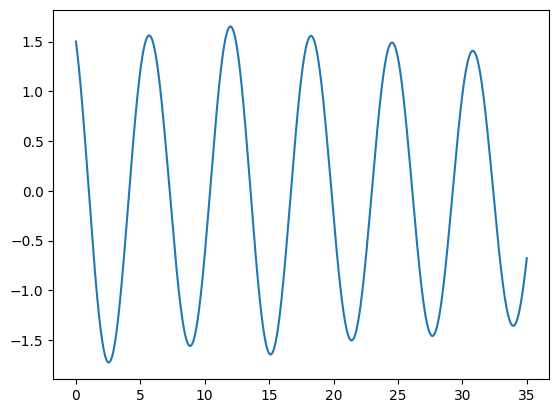

In [9]:
plt.plot(times, result0.expect[0])

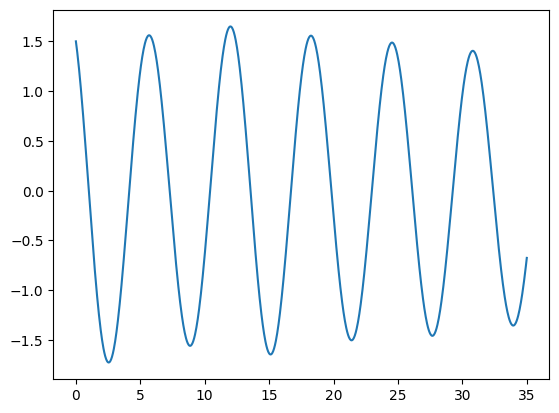

In [10]:
plt.plot(times, result1.expect[0])

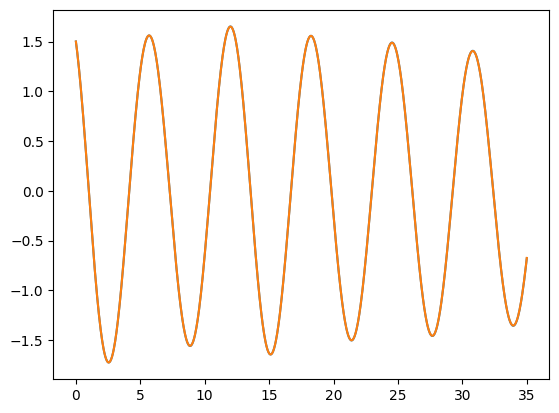

In [11]:
plt.plot(times, result0.expect[0], times, result1.expect[0])

References: ["A Quantum Engineer’s Guide to Superconducting Qubits"](https://arxiv.org/pdf/1904.06560.pdf) and ["Introduction to Quantum Optics"](https://www.carlosnb.com/_files/ugd/b99da1_fa5355be38c448aca09f1584d705c52a.pdf)